<a href="https://colab.research.google.com/github/ivoryRabbit/NIMS_PLIM/blob/gh-pages/5_GradientBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GradientBoosting models

- eXtreme Gradient Boosting 모델과 Light Gradient Boosting 모델을 사용하였습니다.
- 시간관계상 hyperparameter tuning은 grid search 이용 및 경험적(empirical)으로 해결했습니다.
- 두 모델 다 CV stacking ensemble 기법을 사용하였습니다.
- 시간관계상 stacking 및 blending은 생략하고 경험적(empirical)으로 가중평균하였습니다.
- feature를 그대로 사용할게 아니라 차원축소(PCA 또는 autoencoder) 정보를 뽑아 학습시켰다면 어땠을까 합니다.

1. eXtreme Gradient Boosting
    - 결과: 19.40228
2. Light Gradient Boosting(최대)
    - 결과: 19.44618
3. Ensemble
    - 결과: 19.40476

In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
import glob, re, gc, os
np.random.seed(777)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.multioutput import MultiOutputRegressor

!pip install xgboost
!pip install lightgbm

import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

Looking in indexes: http://mirror.kakao.com/pypi/simple
     |████████████████████████████████| 109.8MB 78.4MB/s eta 0:00:01
Looking in indexes: http://mirror.kakao.com/pypi/simple
     |████████████████████████████████| 1.2MB 5.7MB/s eta 0:00:01


In [ ]:
train = pd.read_csv('data/train_clean.csv', index_col = 'id')
test = pd.read_csv('data/test.csv', index_col = 'id')
sample_submission = pd.read_csv('data/sample_submission.csv', index_col = 'id')
print(train.shape, test.shape, sample_submission.shape)

(61651, 125) (10000, 113) (10000, 12)


In [ ]:
X_train = train.loc[:, '2009-06':'2018-05']
y_train = train.loc[:, '2018-06':]
X_test = test.loc[:, '2009-06':]

In [ ]:
X_train, X_test = tuple(map(
    lambda df: df.assign(
        MEAN = lambda x: np.mean(x, axis = 1),
        SD = lambda x: np.std(x, axis = 1),
        KURT = lambda x: sp.stats.kurtosis(x, axis = 1),
        SKEW = lambda x: sp.stats.skew(x, axis = 1),
        ACF = lambda x: x.apply(lambda y: y.autocorr(lag = 12), axis = 1)
    ),
    (X_train, X_test)
))

In [ ]:
X_train, y_train, X_test= list(map(lambda df: df.values, (X_train, y_train, X_test)))

### 0. Hyperparameter tunning

In [ ]:
xgb_params = {
    'objective': 'reg:linear',
    'metric' : 'rmse',
    'eta': 0.02,
    'min_child_weight': 6,
    'colsample_bytree': 0.3,
    'silent': True,
    'seed': 777,
}

[0]	train-rmse:34.74438	test-rmse:34.73801
[100]	train-rmse:17.22583	test-rmse:18.55701
[200]	train-rmse:15.50567	test-rmse:17.80757
[300]	train-rmse:14.87518	test-rmse:17.72716
[400]	train-rmse:14.43920	test-rmse:17.70215
[500]	train-rmse:14.11471	test-rmse:17.70042
[600]	train-rmse:13.80415	test-rmse:17.69929

Best Rounds: 556
Best Score: 17.695961


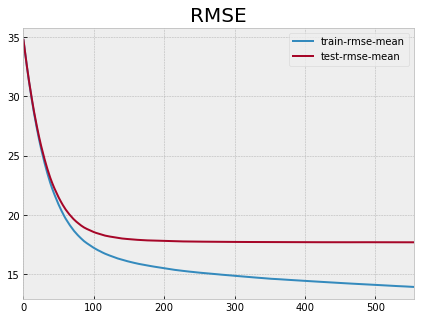

[0]	train-rmse:25.39050	test-rmse:25.39770
[100]	train-rmse:13.77849	test-rmse:15.05187
[200]	train-rmse:12.50266	test-rmse:14.63342
[300]	train-rmse:11.96885	test-rmse:14.60520
[400]	train-rmse:11.61639	test-rmse:14.59943
[500]	train-rmse:11.34437	test-rmse:14.60240

Best Rounds: 431
Best Score: 14.598483400000001


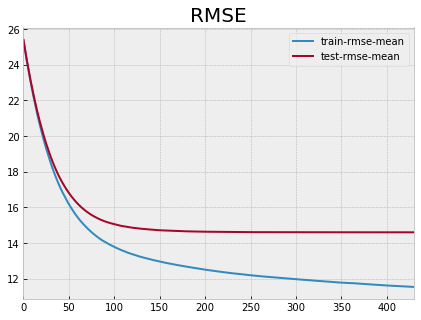

[0]	train-rmse:17.79938	test-rmse:17.79801
[100]	train-rmse:10.35589	test-rmse:11.37098
[200]	train-rmse:9.36809	test-rmse:11.07111
[300]	train-rmse:8.94003	test-rmse:11.03699
[400]	train-rmse:8.65564	test-rmse:11.03141
[500]	train-rmse:8.43494	test-rmse:11.03010
[600]	train-rmse:8.24351	test-rmse:11.03433

Best Rounds: 504
Best Score: 11.0300418


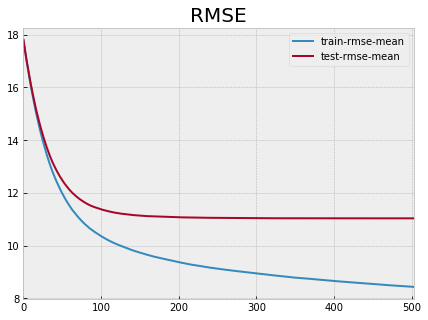

[0]	train-rmse:17.43270	test-rmse:17.43235
[100]	train-rmse:9.62226	test-rmse:10.53661
[200]	train-rmse:8.75207	test-rmse:10.25575
[300]	train-rmse:8.37354	test-rmse:10.23597
[400]	train-rmse:8.13865	test-rmse:10.23274
[500]	train-rmse:7.94475	test-rmse:10.23331

Best Rounds: 433
Best Score: 10.232255799999999


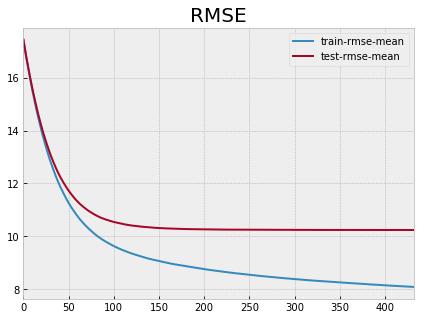

[0]	train-rmse:27.12784	test-rmse:27.13047
[100]	train-rmse:13.23860	test-rmse:13.96261
[200]	train-rmse:12.07225	test-rmse:13.37369
[300]	train-rmse:11.60133	test-rmse:13.30967
[400]	train-rmse:11.30248	test-rmse:13.29745
[500]	train-rmse:11.06743	test-rmse:13.29302
[600]	train-rmse:10.86624	test-rmse:13.29214
[700]	train-rmse:10.68012	test-rmse:13.29485

Best Rounds: 605
Best Score: 13.2917466


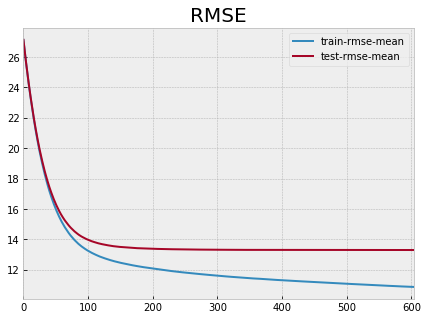

[0]	train-rmse:51.05932	test-rmse:51.06213
[100]	train-rmse:22.81796	test-rmse:23.75708
[200]	train-rmse:20.75071	test-rmse:22.50373
[300]	train-rmse:20.03088	test-rmse:22.38386
[400]	train-rmse:19.54315	test-rmse:22.35074
[500]	train-rmse:19.20680	test-rmse:22.34183
[600]	train-rmse:18.91780	test-rmse:22.34367

Best Rounds: 535
Best Score: 22.3401426


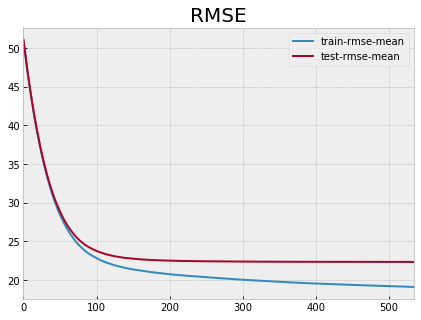

[0]	train-rmse:79.48432	test-rmse:79.49108
[100]	train-rmse:31.93005	test-rmse:33.06165
[200]	train-rmse:28.74752	test-rmse:30.97137
[300]	train-rmse:27.73789	test-rmse:30.78004
[400]	train-rmse:27.05560	test-rmse:30.72464
[500]	train-rmse:26.54684	test-rmse:30.70320
[600]	train-rmse:26.10138	test-rmse:30.69856
[700]	train-rmse:25.71707	test-rmse:30.69817

Best Rounds: 607
Best Score: 30.697389999999995


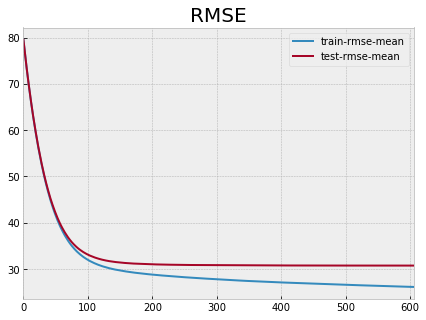

[0]	train-rmse:129.38022	test-rmse:129.38704
[100]	train-rmse:46.29880	test-rmse:47.72365
[200]	train-rmse:41.37296	test-rmse:44.19448
[300]	train-rmse:40.23096	test-rmse:44.01844
[400]	train-rmse:39.51550	test-rmse:43.99095
[500]	train-rmse:38.91064	test-rmse:43.97529
[600]	train-rmse:38.35004	test-rmse:43.97347
[700]	train-rmse:37.82556	test-rmse:43.97320

Best Rounds: 648
Best Score: 43.9691672


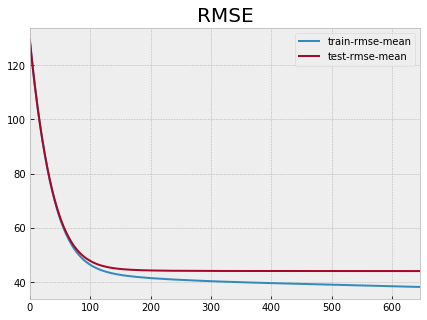

[0]	train-rmse:122.24217	test-rmse:122.24840
[100]	train-rmse:44.41133	test-rmse:45.81778
[200]	train-rmse:39.86730	test-rmse:42.60012
[300]	train-rmse:38.78425	test-rmse:42.45206
[400]	train-rmse:38.11924	test-rmse:42.43827
[500]	train-rmse:37.54783	test-rmse:42.43898

Best Rounds: 417
Best Score: 42.435702400000004


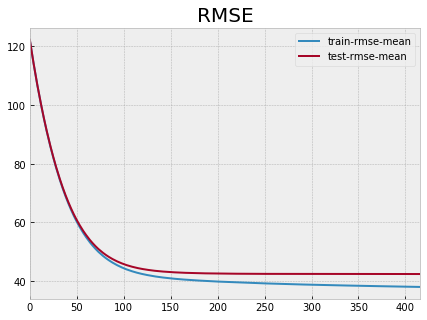

[0]	train-rmse:96.02067	test-rmse:96.02653
[100]	train-rmse:37.90025	test-rmse:39.22151
[200]	train-rmse:34.33668	test-rmse:36.89208
[300]	train-rmse:33.36353	test-rmse:36.77430
[400]	train-rmse:32.76184	test-rmse:36.76057
[500]	train-rmse:32.30713	test-rmse:36.76001

Best Rounds: 440
Best Score: 36.757622000000005


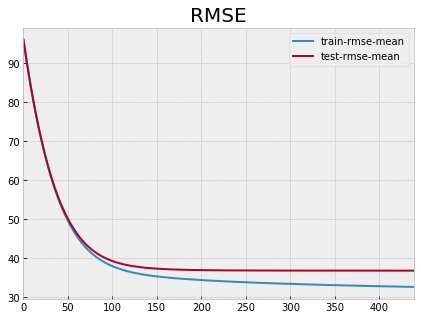

[0]	train-rmse:79.59028	test-rmse:79.59255
[100]	train-rmse:33.60204	test-rmse:34.82552
[200]	train-rmse:30.78020	test-rmse:33.03597
[300]	train-rmse:30.03074	test-rmse:32.93192
[400]	train-rmse:29.52798	test-rmse:32.91590
[500]	train-rmse:29.08239	test-rmse:32.91914

Best Rounds: 409
Best Score: 32.9143808


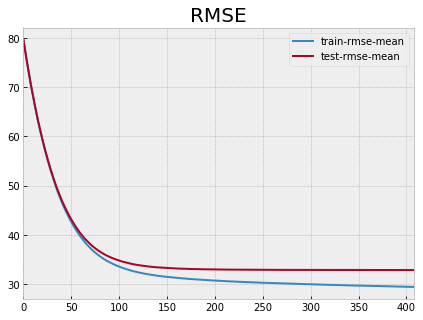

[0]	train-rmse:52.02780	test-rmse:52.03114
[100]	train-rmse:24.40044	test-rmse:25.60473
[200]	train-rmse:22.33293	test-rmse:24.51059
[300]	train-rmse:21.66922	test-rmse:24.42282
[400]	train-rmse:21.22823	test-rmse:24.40858

Best Rounds: 393
Best Score: 24.407309


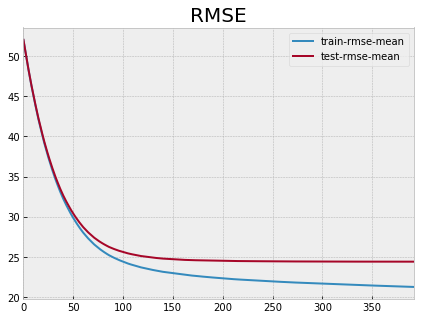

In [ ]:
best_rounds_list = list()
score_list = list()
for i in range(12):
    dtrain = xgb.DMatrix(X_train, y_train[:, i])
    dtest = xgb.DMatrix(X_test)
    cv_output = xgb.cv(xgb_params,
                       dtrain,                        
                       num_boost_round = 1000,         # 학습 횟수
                       early_stopping_rounds = 100,    # overfitting 방지
                       nfold = 5,                      # 높을 수록 실제 검증값에 가까워지고 낮을 수록 빠름
                       verbose_eval = 100,             # 몇 번째마다 메세지를 출력할 것인지
                       maximize = False,
                       show_stdv = False,              # 학습 동안 std(표준편차) 출력할지 말지
                       )

    best_rounds = cv_output.index.size
    score = cv_output.iloc[-1]['test-rmse-mean']
    best_rounds_list.append(best_rounds)
    score_list.append(score)
    
    print(f'\nBest Rounds: {best_rounds}')
    print(f'Best Score: {score}')

    fig, ax = plt.subplots(figsize = (7, 5))
    cv_output[['train-rmse-mean', 'test-rmse-mean']].plot(ax = ax)
    ax.set_title('RMSE', fontsize=20)

    plt.show()

In [ ]:
print('Average score is', np.mean(score_list))

Average score is 25.030850216666668


### 1. eXtreme Gradient Boosting

In [ ]:
# 5-fold data splitting
n_splits = 5
folds = KFold(n_splits = n_splits, shuffle = False, random_state = 777)

In [ ]:
# XGB + CV ensemble 학습모델
pred_xgb_train = np.zeros(y_train.shape)
pred_xgb_test = np.zeros(sample_submission.shape)

for train_index, valid_index in folds.split(X_train):
    XX_train, XX_valid = X_train[train_index], X_train[valid_index]
    yy_train, yy_valid = y_train[train_index], y_train[valid_index]
    for i in range(12):
        model_xgb = xgb.XGBRegressor(
            metric = 'rmse',
            n_estimators = 2000, 
            learning_rate = 0.01,
            colsample_bytree = 0.3,
            reg_alpha = 0.05,
            reg_lambda = 0.8,
        )
        model_xgb.fit(
            XX_train, yy_train[:, i],
            eval_set = [(XX_valid, yy_valid[:, i])],
            early_stopping_rounds = 50,
            verbose = 100
        )
        best_iteration = model_xgb.get_booster().best_iteration

        pred_xgb_train[valid_index, i] = model_xgb.predict(XX_valid, ntree_limit = best_iteration)
        pred_xgb_test[:, i] += model_xgb.predict(X_test, ntree_limit = best_iteration) / n_splits

[0]	validation_0-rmse:30.48752
Will train until validation_0-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:16.96630
[200]	validation_0-rmse:13.77206
[300]	validation_0-rmse:13.11529
[400]	validation_0-rmse:12.95577
[500]	validation_0-rmse:12.87084
[600]	validation_0-rmse:12.82962
[700]	validation_0-rmse:12.79387
[800]	validation_0-rmse:12.78421
[900]	validation_0-rmse:12.77928
[1000]	validation_0-rmse:12.76821
[1100]	validation_0-rmse:12.75975
Stopping. Best iteration:
[1092]	validation_0-rmse:12.75935

[0]	validation_0-rmse:21.95327
Will train until validation_0-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:13.04435
[200]	validation_0-rmse:10.99877
[300]	validation_0-rmse:10.57201
[400]	validation_0-rmse:10.46778
[500]	validation_0-rmse:10.42162
[600]	validation_0-rmse:10.39523
[700]	validation_0-rmse:10.37997
[800]	validation_0-rmse:10.37740
Stopping. Best iteration:
[849]	validation_0-rmse:10.37640

[0]	validation_0-rmse:15.25821
Will train until validation

Will train until validation_0-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:40.42487
[200]	validation_0-rmse:31.41331
[300]	validation_0-rmse:29.70967
[400]	validation_0-rmse:29.32200
[500]	validation_0-rmse:29.17250
[600]	validation_0-rmse:29.10335
[700]	validation_0-rmse:29.06219
[800]	validation_0-rmse:29.04470
[900]	validation_0-rmse:29.03846
Stopping. Best iteration:
[916]	validation_0-rmse:29.03623

[0]	validation_0-rmse:127.63399
Will train until validation_0-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:62.17240
[200]	validation_0-rmse:45.69236
[300]	validation_0-rmse:42.68427
[400]	validation_0-rmse:42.16996
[500]	validation_0-rmse:42.04825
[600]	validation_0-rmse:42.00705
[700]	validation_0-rmse:41.99297
[800]	validation_0-rmse:41.98421
Stopping. Best iteration:
[812]	validation_0-rmse:41.98293

[0]	validation_0-rmse:119.34875
Will train until validation_0-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:58.21017
[200]	validation_0-rmse:43.

[1100]	validation_0-rmse:12.74940
[1200]	validation_0-rmse:12.74775
Stopping. Best iteration:
[1224]	validation_0-rmse:12.74572

[0]	validation_0-rmse:21.78896
Will train until validation_0-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:12.88240
[200]	validation_0-rmse:10.86077
[300]	validation_0-rmse:10.45461
[400]	validation_0-rmse:10.35594
[500]	validation_0-rmse:10.31070
[600]	validation_0-rmse:10.28288
[700]	validation_0-rmse:10.26243
[800]	validation_0-rmse:10.25455
[900]	validation_0-rmse:10.25046
[1000]	validation_0-rmse:10.24543
[1100]	validation_0-rmse:10.24356
Stopping. Best iteration:
[1088]	validation_0-rmse:10.24240

[0]	validation_0-rmse:15.28033
Will train until validation_0-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:10.03332
[200]	validation_0-rmse:8.85480
[300]	validation_0-rmse:8.59302
[400]	validation_0-rmse:8.51037
[500]	validation_0-rmse:8.47789
[600]	validation_0-rmse:8.45671
[700]	validation_0-rmse:8.44481
[800]	validation_0-rmse:8.43

Will train until validation_0-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:61.73309
[200]	validation_0-rmse:45.34759
[300]	validation_0-rmse:42.41757
[400]	validation_0-rmse:41.91838
[500]	validation_0-rmse:41.79814
[600]	validation_0-rmse:41.74477
[700]	validation_0-rmse:41.71668
Stopping. Best iteration:
[716]	validation_0-rmse:41.71359

[0]	validation_0-rmse:120.59031
Will train until validation_0-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:59.44003
[200]	validation_0-rmse:44.16108
[300]	validation_0-rmse:41.32435
[400]	validation_0-rmse:40.81672
[500]	validation_0-rmse:40.69237
[600]	validation_0-rmse:40.65121
[700]	validation_0-rmse:40.63578
Stopping. Best iteration:
[724]	validation_0-rmse:40.63473

[0]	validation_0-rmse:92.98019
Will train until validation_0-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:47.59723
[200]	validation_0-rmse:36.88588
[300]	validation_0-rmse:35.03624
[400]	validation_0-rmse:34.72277
[500]	validation_0-rmse:34.6

In [ ]:
y_true = y_train
y_pred = pred_xgb_train

In [ ]:
np.mean(np.sqrt(np.mean(np.square(y_true - y_pred), axis = 0)))

22.59963215250596

In [ ]:
validation = pd.DataFrame(data = pred_xgb_train, columns = sample_submission.columns, index = train.index)
validation.to_csv('submissions/validation_XGB_2.csv')

In [ ]:
validation = pd.read_csv('submissions/validation_XGB_2.csv', index_col = 'id')

In [ ]:
X_sample, y_sample = train.iloc[3, :-12], train.iloc[3, -12:]
y_pred = validation.iloc[3]

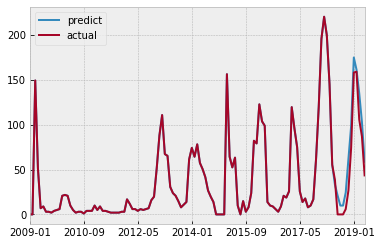

In [ ]:
pd.concat([X_sample, y_pred]).plot()
pd.concat([X_sample, y_sample]).plot()
plt.legend(['predict', 'actual'])
plt.show()

In [ ]:
sample_submission = pd.DataFrame(data = pred_xgb_test, columns = sample_submission.columns, index = sample_submission.index)
sample_submission.to_csv('submissions/submission_XGB_2.csv')

### 2. Light Gradient Boosting

In [ ]:
# LGB + CV ensemble 학습모델
pred_lgb_train = np.zeros(y_train.shape)
pred_lgb_test = np.zeros(sample_submission.shape)

for train_index, valid_index in folds.split(X_train):
    XX_train, XX_valid = X_train[train_index], X_train[valid_index]
    yy_train, yy_valid = y_train[train_index], y_train[valid_index]
    for i in range(12):
        model_lgb = lgb.LGBMRegressor(
            objective = 'regression',
            metric = 'rmse',
            n_estimators = 2000,
            learning_rate = 0.01,
            colsample_bytree = 0.3,
            reg_alpha = 0.05,
            reg_lambda = 0.8,
        )
        model_lgb.fit(
            XX_train, yy_train[:, i],
            eval_set = [(XX_valid, yy_valid[:, i])],
            early_stopping_rounds = 50,
            verbose = 100
        )
        best_iteration = model_lgb.best_iteration_

        pred_lgb_train[valid_index, i] = model_lgb.predict(XX_valid, ntree_limit = best_iteration)
        pred_lgb_test[:, i] += model_lgb.predict(X_test, ntree_limit = best_iteration) / n_splits

Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 14.7959
[200]	valid_0's rmse: 13.376
[300]	valid_0's rmse: 13.0092
[400]	valid_0's rmse: 12.8792
[500]	valid_0's rmse: 12.818
[600]	valid_0's rmse: 12.7904
[700]	valid_0's rmse: 12.7721
[800]	valid_0's rmse: 12.76
[900]	valid_0's rmse: 12.7569
Early stopping, best iteration is:
[889]	valid_0's rmse: 12.7554
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 11.6039
[200]	valid_0's rmse: 10.7393
[300]	valid_0's rmse: 10.5074
[400]	valid_0's rmse: 10.4287
[500]	valid_0's rmse: 10.3925
[600]	valid_0's rmse: 10.3734
[700]	valid_0's rmse: 10.367
[800]	valid_0's rmse: 10.3628
[900]	valid_0's rmse: 10.3564
[1000]	valid_0's rmse: 10.3557
Early stopping, best iteration is:
[1013]	valid_0's rmse: 10.3535
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 9.1845
[200]	valid_0's rmse: 8.63368
[300]	valid_0's rmse: 8.48753
[400]	valid_0's rmse: 8.4262
[5

[100]	valid_0's rmse: 45.8542
[200]	valid_0's rmse: 41.4019
[300]	valid_0's rmse: 40.6066
[400]	valid_0's rmse: 40.4431
[500]	valid_0's rmse: 40.4015
[600]	valid_0's rmse: 40.3876
[700]	valid_0's rmse: 40.3852
Early stopping, best iteration is:
[672]	valid_0's rmse: 40.3835
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 39.0834
[200]	valid_0's rmse: 35.5033
[300]	valid_0's rmse: 34.7863
[400]	valid_0's rmse: 34.6022
[500]	valid_0's rmse: 34.529
[600]	valid_0's rmse: 34.4979
[700]	valid_0's rmse: 34.479
[800]	valid_0's rmse: 34.469
[900]	valid_0's rmse: 34.4635
[1000]	valid_0's rmse: 34.4614
Early stopping, best iteration is:
[961]	valid_0's rmse: 34.4574
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 33.9881
[200]	valid_0's rmse: 31.0618
[300]	valid_0's rmse: 30.534
[400]	valid_0's rmse: 30.4214
[500]	valid_0's rmse: 30.384
[600]	valid_0's rmse: 30.3789
Early stopping, best iteration is:
[576]	valid_0's rmse: 30.37

[100]	valid_0's rmse: 9.16398
[200]	valid_0's rmse: 8.59838
[300]	valid_0's rmse: 8.45637
[400]	valid_0's rmse: 8.41362
[500]	valid_0's rmse: 8.39579
[600]	valid_0's rmse: 8.38619
[700]	valid_0's rmse: 8.38054
Early stopping, best iteration is:
[702]	valid_0's rmse: 8.38027
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 13.2754
[200]	valid_0's rmse: 12.2314
[300]	valid_0's rmse: 11.9633
[400]	valid_0's rmse: 11.8706
[500]	valid_0's rmse: 11.8286
[600]	valid_0's rmse: 11.8108
[700]	valid_0's rmse: 11.8033
[800]	valid_0's rmse: 11.7993
Early stopping, best iteration is:
[795]	valid_0's rmse: 11.7987
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 24.1653
[200]	valid_0's rmse: 21.8054
[300]	valid_0's rmse: 21.229
[400]	valid_0's rmse: 21.0447
[500]	valid_0's rmse: 20.9585
[600]	valid_0's rmse: 20.9122
[700]	valid_0's rmse: 20.8902
[800]	valid_0's rmse: 20.8769
[900]	valid_0's rmse: 20.8665
[1000]	valid_0's rmse: 20.863

[500]	valid_0's rmse: 20.2485
[600]	valid_0's rmse: 20.2255
[700]	valid_0's rmse: 20.2143
Early stopping, best iteration is:
[727]	valid_0's rmse: 20.2137


In [ ]:
y_true = y_train
y_pred = pred_lgb_train

In [ ]:
np.mean(np.sqrt(np.mean(np.square(y_true - y_pred), axis = 0)))

22.588940221613736

In [ ]:
validation = pd.DataFrame(data = pred_lgb_train, columns = sample_submission.columns, index = train.index)
validation.to_csv('submissions/validation_LGB_2.csv')

In [ ]:
validation = pd.read_csv('submissions/validation_LGB_2.csv', index_col = 'id')

In [ ]:
X_sample, y_sample = train.iloc[3, :-12], train.iloc[3, -12:]
y_pred = validation.iloc[3]

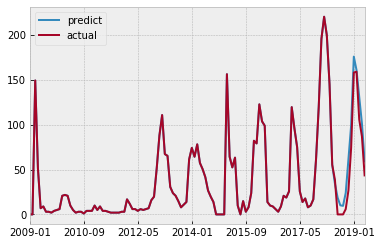

In [ ]:
pd.concat([X_sample, y_pred]).plot()
pd.concat([X_sample, y_sample]).plot()
plt.legend(['predict', 'actual'])
plt.show()

In [ ]:
sample_submission = pd.DataFrame(data = pred_lgb_test, columns = sample_submission.columns, index = sample_submission.index)
sample_submission.to_csv('submissions/submission_LGB_2.csv')

### 3. Ensemble

In [ ]:
# 가중평균... 사용하지 않음
y_true = y_train
y_pred = .4 * pred_xgb_train + .6 * pred_lgb_train

In [ ]:
np.mean(np.sqrt(np.mean(np.square(y_true - y_pred), axis = 0)))

22.581184730742738

In [ ]:
pred = .4 * pred_xgb_test + .6 * pred_lgb_test

In [ ]:
sample_submission = pd.DataFrame(data = pred, columns = sample_submission.columns, index = sample_submission.index)
sample_submission.to_csv('submissions/submission_Ensemble_2.csv')